# Empirical Bayes uncertainty estimation for (U–Th)/He data

This Jupyter notebook demonstrates the use of empirical Bayes (also known as hierarchical Bayes) resampling for more robust (U-Th)/He data uncertainty estimation for use in thermal-history inversions. See [Malinverno and Briggs (2004)](https://doi.org/10.1190/1.1778243) for descriptions of the general Bayesian method. As described and implemented here, it is particularly suited for zircon datasets (high n) that span a broad range of effective uranium (eU). The aim is to expand uncertainty accounting where the hyperparameters (i.e., observed He dates) will have a prior distribution that expresses their initial uncertainty and a posterior distribution that is determined by the data directly. The individual date errors are treated as hyperparameters drawn from a probability distribution and the variance is used to infer the 'empirical' date uncertainty. This weighted 1σ uncertainty is inferred from the scatter of the data as determined by the standard deviation of the data weighted by a Gaussian kernel in eU space (σeU = 100 ppm). The 100 ppm eU kernel is taken to represent the range over which zircon grains with similar eU should have similar ages. This value was chosen as a good balance because smaller values tend to converge on the internal uncertainty and larger values begin to reduce the influence of individual dates during thermal modelling. The empirical uncertainty is estimated by summing the internal and external uncertainties in quadrature. Importantly, the Bayes approach retains the observed date calculated from the measured isotopic data but the uncertainties are estimated from the data directly. Error resampling is helpful during modelling when errors are underestimated and prevents the t–T search algorithm from becoming trapped in local minima (in the case of learning algorithms such as Markov chain Monte Carlo) by reducing overprecision.

Helium data are typically overdispersed with respect to analytical uncertainties (approx. 2-5% for apatite and zircon). The age reproducibility of helium age standards such as the Durango (DUR) apatite and Fish Canyon Tuff (FCT) zircon suggest uncertainties are greater, on the order of 6-7% for apatite and 8-10% for zircon. These are still likely minimum estimates, since those grains are standards with well-behaved laboratory diffusion behavior. For more information regarding date reproducibility and ICPMS measurements, see Reiners and Nicolescu (2006) (https://www.geo.arizona.edu/~reiners/arhdl/arhdlrep1.pdf), [Guenthner et al. (2016)](https://doi.org/10.1002/2016GC006311) for U–Th/He, and [Gleadow et al. (2015)](https://doi.org/10.1016/j.epsl.2015.05.003) for FCT specifically. 

Natural, 'wild' samples typically have total uncertainties that exceed 10% due various reasons such as (unaccounted for) isotopic zoning, imperfect grain measurement/grain morphology characterization for alpha-loss correction, or unidentified mineral or fluid inclusions (to name a few). There is also the possibility for trapping of pre- and post-'closure' 4He in various grain sinks and imperfections that further complicate the age reproducibility of slowly cooled apatite; see [Zeitler et al. (2017)](https://doi.org/10.1016/j.gca.2017.03.041), [McDannell et al. (2018)](https://doi.org/10.1016/j.gca.2017.11.031), and [Guo et al. (2021)](https://doi.org/10.1016/j.gca.2021.07.015) for recent experiments and information on He age dispersion and diffusion systematics in apatite.

Note: some publications "bin" single-grain dates by eU and then average the dates in each bin to create 'synthetic' He dates, but this approach lacks rigor and quickly becomes an arbitrary exercise depending on data quality and quantity. This is even more problematic for apatite dates that normally span a narrow eU range. This approach is usually carried out for time-temperature (t-T) modelling, however, it artificially increases date errors, and as a result, makes it easier to meet p-value statistical thresholds of acceptance for pure Monte Carlo modelling. Do not do this. Since most age dispersion is explainable to first-order by the effects of radiation damage on diffusivity, each grain is a separate thermochronometer (that is the advantage of using radiation-damage models in the first place!). Averaging dates results in a loss of valuable t-T information.

## Load required Julia packages

In [1]:
## --- Load (and install if neccesary) the StatGeochem package

using Plots, Statistics, StatGeochem

## Enter sample information

First we read in our sample information for completeness and record-keeping purposes for output

sample name; equivalent spherical radius (ESR) or grain halfwidth; U-Th-(Sm) are used for calculating eU;
and the observed uncorrected He age and its corresponding 1σ uncertainty. A row can be added for Sm if required and the eU equation will have to be updated accordingly. See [Cooperdock et al. (2019)](https://gchron.copernicus.org/articles/1/17/2019/), for the most recent and complete eU equation(s) and derivation: eU = U + 0.238 x Th + 0.0012 x Sm

In [2]:
ds = Dict{String, Union{Vector{Float64}, Vector{String}}}()
ds["Name"] = ["04RF1zA","04SC1zB","04SC1zA","04GF1zB","04GF1zA","04RF1zB","04MT1zA","04R1zB","04MT1zB","04R1zA","04MT1zF","04EQ1zA","04EQ1zF","04SH1zB","04EQ1zB","04MT1zD","04MT1zC","04MT1zE","04SG1zB","04EQ1zC","04EQ1zE","04EQ1zD","04SH1zA",]
ds["ESR"] = ESR = [64,71,47,63,56,72,67,51,68,42,54,41,43,56,42,80,45,49,55,36,35,31,50.,]
ds["U [ppm]"] = U = [84,415,422,254,247,155,362,580,346,656,567,781,647,883,748,739,980,974,1738,894,1107,866,1011.,]
ds["Th [ppm]"] = Th = [67.3,111,110,104,88.4,177,88.8,174,78,167,75.48,203,284,184,218,140.59,251.7,197.01,1171,246,351,166,228,]
ds["Age [Ma]"] = Age = [770,659,649,638.4,619.8,557,545,500,493,357,329,253,240.8,224.6,224.5,217,193,190,72,57,42,29.5,11.4,]
ds["Age_sigma [Ma]"] = Age_sigma = [15.0,51.0,13.0,12.6,18.4,10.0,12.0,10.0,43.0,7.0,7.0,5.2,4.6,4.6,6.0,5.0,4.0,4.0,2.0,1.1,1.1,0.8,0.2,]
ds["eU [ppm]"] = eU = U+.238*Th

23-element Vector{Float64}:
  100.0174
  441.418
  448.18
  278.752
  268.0392
  197.126
  383.1344
  621.412
  364.564
  695.746
  584.96424
  829.314
  714.592
  926.792
  799.884
  772.46042
 1039.9046
 1020.88838
 2016.6979999999999
  952.548
 1190.538
  905.508
 1065.264

#### optional: set minimum 1σ error to 5% for zircon date, if not already so

In [3]:
#t = Age_sigma .< (0.05.*Age)
#Age_sigma[t] = (0.05.*Age)[t]

## Calculate the empirical standard deviation on the single-grain dates and plot the results

Standard deviation of the Gaussian kernel in eU space representing the range over which grains with similar eU should have similar ages. Plotting x,y with both internal and 'empirical' date uncertainties.

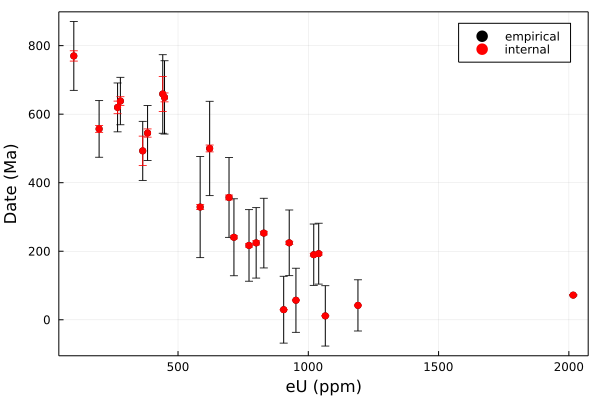

Age_sigma_empirical:
[100.38, 114.59, 106.97, 69.255, 71.319, 82.6, 80.168, 137.7, 86.172, 116.37, 147.67, 101.69, 112.32, 95.853, 102.76, 104.41, 88.848, 89.474, 2.0, 93.535, 74.705, 97.554, 88.053]


In [4]:
σeU = 100

# Calculate errors
ds["Age_sigma_empirical [Ma]"] = Age_sigma_empirical = zeros(length(Age))
for i = 1:length(Age)
    W = normpdf.(eU[i], σeU, eU)
    σ_external = nanstd(Age, W)
    σ_internal = Age_sigma[i]
    Age_sigma_empirical[i] = sqrt(σ_external^2 + σ_internal^2)
end

h = plot(xlabel="eU (ppm)", ylabel="Date (Ma)", framestyle=:box)
plot!(eU, Age, yerror=Age_sigma_empirical, seriestype=:scatter, c=:black, msc=:black, label="empirical")
plot!(eU, Age, yerror=Age_sigma, seriestype=:scatter, c=:red, msc=:red, label="internal")
xq = range(minimum(eU), maximum(eU), length=300)
savefig(h,"Age_sigma_empirical.pdf")
display(h)

println("Age_sigma_empirical:")
println(round.(Age_sigma_empirical, sigdigits=5))

exportdataset(ds, "sample-emp.csv", ',')